# 2o Estágio: Treinamento do Modelo de Identificação de Baleias e Golfinhos

## Objetivo

Este notebook tem por objetivo treinar o segundo estágio do pipeline, que consiste no modelo de identificação de baleias e golfinhos.

`INSTITUIÇÃO: PONTIFÍCIA UNIVERSIDADE CATÓLICA DE MINAS GERAIS`

`CURSO: PÓS-GRADUAÇÃO LATO SENSU EM INTELIGÊNCIA ARTIFICAL E APRENDIZADO DE MÁQUINA`

`ALUNO: ROBSON TADEU DA CRUZ SANTOS`

`PROJETO: IDENTIFICAÇÃO DE BALEIAS E GOLFINHOS ATRAVÉS DE SUAS CARACTERÍSTICAS`

O projeto tem por objetivo final criar solução de aprendizado de máquina para identificar a identidade de baleias e golfinhos a partir de imagens. O foco deste notebook será de realizar análise exploratória.

## Instalação 🛠

In [1]:
!pip install -q efficientnet
!pip install -q tensorflow_addons
!pip install -q tfimm
!pip install -q timm

## Importando Bibliotecas 📚

In [2]:
import re
import os
import numpy as np
import pandas as pd
import random
import math
import tensorflow as tf
import efficientnet.tfkeras as efn
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pickle
import json
import tensorflow_hub as tfhub
from datetime import datetime
import tfimm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# configurando TPUs
try:
    # Tenta identificar se existe TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('TPU OK', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Estratégica default do TF para distribuir tarefas
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
print("REPLICAS: ", strategy.num_replicas_in_sync)

TPU OK grpc://10.1.29.178:8470
REPLICAS:  8


## Configuração 📈

In [5]:
class CFG:
    exp_code = 'e_10001'
    root_dir = f'/content/drive/MyDrive/Competicoes/pos_puc/'
    seed = 42
    fold = 1
    n_folds = 5
    DEBUG = False
    evaluate = True
    # Retornar de onde parou no treinamento em caso de interrupção do serviço
    resume = False
    resume_epoch = None
    # Parametros
    batch_size = 4 * strategy.num_replicas_in_sync
    image_size = 512
    n_classes = 15587
    # Modelo
    model_type = 'effnetv1'  
    model_name = None
    eff_net = 0
    freeze_batch_norm = False
    head = 'arcface' 
    epochs = 20
    lr = 0.001
    message='baseline'
    # Augmentations
    cutout = False
    # Salvar
    save_dir = f'{root_dir}/experimentos/{exp_code}/fold_{fold}'
    resume_model_wts = save_dir + '/effnetv1_b6_last.h5'
    # Numero de vizinhos próximos para realizar a consulta
    KNN = 100
    # Dataset
    # Endereço na Google Cloud dos arquivos TFRecord
    # Cuidado que mais ou menos a cada semana esse endereço muda, sendo
    # necessário obter novo endereço
    gcs_ds_path = 'gs://kds-cff8ba45c7d0f4747d04396fe2a7a9ff59eeedc2005aea3fec345318'
    

# Funcao para contar o numero de imagens a partir dos arquivos tfrecord
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)


# Para reproducibilidade
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    

def is_interactive():
    return 'runtime' in get_ipython().config.IPKernelApp.connection_file


os.makedirs(CFG.save_dir, exist_ok=True)
IS_INTERACTIVE = is_interactive()
print(IS_INTERACTIVE)

True


In [6]:
if CFG.model_type == 'effnetv1':
    CFG.model_name = f'effnetv1_b{CFG.eff_net}'
elif CFG.model_type == 'effnetv2':
    CFG.model_name = f'effnetv2_{CFG.eff_net}'
elif CFG.model_type == 'resnet152':
    CFG.model_name = f'resnet152'
elif CFG.model_type == 'tfimm':
    CFG.model_name = f'{CFG.model_name}'

print(CFG.model_name)

effnetv1_b0


In [7]:
train_files = (
    np.concatenate(
      [
       np.sort(np.array(tf.io.gfile.glob(CFG.gcs_ds_path + '/train*.tfrec'))),        
    ]
))
test_files = np.concatenate([
  np.sort(np.array(tf.io.gfile.glob(CFG.gcs_ds_path + '/test*.tfrec'))),
]) 

print(CFG.gcs_ds_path)
print(len(train_files),len(test_files), count_data_items(train_files),count_data_items(test_files))
print(train_files)
print(test_files)

gs://kds-cff8ba45c7d0f4747d04396fe2a7a9ff59eeedc2005aea3fec345318
30 28 51033 27956
['gs://kds-cff8ba45c7d0f4747d04396fe2a7a9ff59eeedc2005aea3fec345318/train-0-1702.tfrec'
 'gs://kds-cff8ba45c7d0f4747d04396fe2a7a9ff59eeedc2005aea3fec345318/train-1-1702.tfrec'
 'gs://kds-cff8ba45c7d0f4747d04396fe2a7a9ff59eeedc2005aea3fec345318/train-10-1701.tfrec'
 'gs://kds-cff8ba45c7d0f4747d04396fe2a7a9ff59eeedc2005aea3fec345318/train-11-1701.tfrec'
 'gs://kds-cff8ba45c7d0f4747d04396fe2a7a9ff59eeedc2005aea3fec345318/train-12-1701.tfrec'
 'gs://kds-cff8ba45c7d0f4747d04396fe2a7a9ff59eeedc2005aea3fec345318/train-13-1701.tfrec'
 'gs://kds-cff8ba45c7d0f4747d04396fe2a7a9ff59eeedc2005aea3fec345318/train-14-1701.tfrec'
 'gs://kds-cff8ba45c7d0f4747d04396fe2a7a9ff59eeedc2005aea3fec345318/train-15-1701.tfrec'
 'gs://kds-cff8ba45c7d0f4747d04396fe2a7a9ff59eeedc2005aea3fec345318/train-16-1701.tfrec'
 'gs://kds-cff8ba45c7d0f4747d04396fe2a7a9ff59eeedc2005aea3fec345318/train-17-1701.tfrec'
 'gs://kds-cff8ba45c7d0f4747

In [8]:
def arcface_format(posting_id, image, label_group, matches, species):
    return posting_id, {'inp1': image, 'inp2': label_group, 'inp3': species}, {'out1': label_group, 'out2': species}, matches, species


def arcface_inference_format(posting_id, image, label_group, matches, species):
    return image,posting_id


def arcface_eval_format(posting_id, image, label_group, matches, species):
    return image,  label_group


# Augmentation
def data_augment(posting_id, image, label_group, matches, species):
    # Cutout
    if tf.random.uniform([])>0.5 and CFG.cutout:
      N_CUTOUT = 6
      for cutouts in range(N_CUTOUT):
        if tf.random.uniform([])>0.5:
           DIM = CFG.image_size
           CUTOUT_LENGTH = DIM//8
           x1 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
           x2 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
           filter_ = tf.concat([tf.zeros((x1,CUTOUT_LENGTH)),tf.ones((CUTOUT_LENGTH,CUTOUT_LENGTH)),tf.zeros((DIM-x1-CUTOUT_LENGTH,CUTOUT_LENGTH))],axis=0)
           filter_ = tf.concat([tf.zeros((DIM,x2)),filter_,tf.zeros((DIM,DIM-x2-CUTOUT_LENGTH))],axis=1)
           cutout = tf.reshape(1-filter_,(DIM,DIM,1))
           image = cutout*image

    if tf.random.uniform([]) < 0.58283:
      image = tf.image.random_jpeg_quality(image, 82, 100)
    image = tf.image.random_flip_left_right(image)
    # image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.0095842)
    image = tf.image.random_saturation(image, 0.95502257, 1.410568)
    image = tf.image.random_contrast(image, 0.23523, 0.68356)
    image = tf.image.random_brightness(image, 0.20807)
    return posting_id, image, label_group, matches, species


# Funcão para decodificar imagens
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.image.resize(image, [CFG.image_size, CFG.image_size])
    image = tf.cast(image, tf.float32) / 255.0
    return image


# Funcao para ler dados dos arquivos FFRecord
def read_labeled_tfrecord(example, train):
    if train == True:
      LABELED_TFREC_FORMAT = {
        "image_id": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "species": tf.io.FixedLenFeature([], tf.int64),
        "individual_id": tf.io.FixedLenFeature([], tf.int64)
      }
    elif train == False:
      LABELED_TFREC_FORMAT = {
        "image_id": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string)
      }

    else:
      raise ValueError(f"train informado errado {train}")

    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    posting_id = example['image_id']
    image = decode_image(example['image'])

    if train == True:
      label_group = tf.cast(example['individual_id'], tf.int32)
      species = tf.cast(example['species'], tf.int32)
    else:
      label_group = -1
      species = -1
    matches = 1
    return posting_id, image, label_group, matches, species


# Função para iniciar leitura dos arquivos TFRecord a partir dos arquivos
def load_dataset(filenames, train=True, ordered = False):
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(lambda example: read_labeled_tfrecord(example, train=train), num_parallel_calls = AUTO) 
    return dataset


# Função para obter os tensores de treino
def get_training_dataset(filenames):
    dataset = load_dataset(filenames, ordered = False)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.map(lambda posting_id, image, label_group, matches, species: (image, label_group))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(CFG.batch_size)
    dataset = dataset.prefetch(AUTO)
    return dataset


# Função para obter os tensores de validação
def get_val_dataset(filenames):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.map(lambda posting_id, image, label_group, matches, species: (image, label_group))
    dataset = dataset.batch(CFG.batch_size)
    dataset = dataset.prefetch(AUTO)
    return dataset


# Função para obter os tensores de avaliação
def get_eval_dataset(filenames, get_targets = True):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_eval_format, num_parallel_calls = AUTO)
    if not get_targets:
        dataset = dataset.map(lambda image, target: image)
    dataset = dataset.batch(CFG.batch_size)
    dataset = dataset.prefetch(AUTO)
    return dataset


# Função para obter os tensores de teste
def get_test_dataset(filenames, get_names = True):
    dataset = load_dataset(filenames, train = False, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_inference_format, num_parallel_calls = AUTO)
    if not get_names:
        dataset = dataset.map(lambda image, posting_id: image)
    dataset = dataset.batch(CFG.batch_size)
    dataset = dataset.prefetch(AUTO)
    return dataset

## Visualização

51033


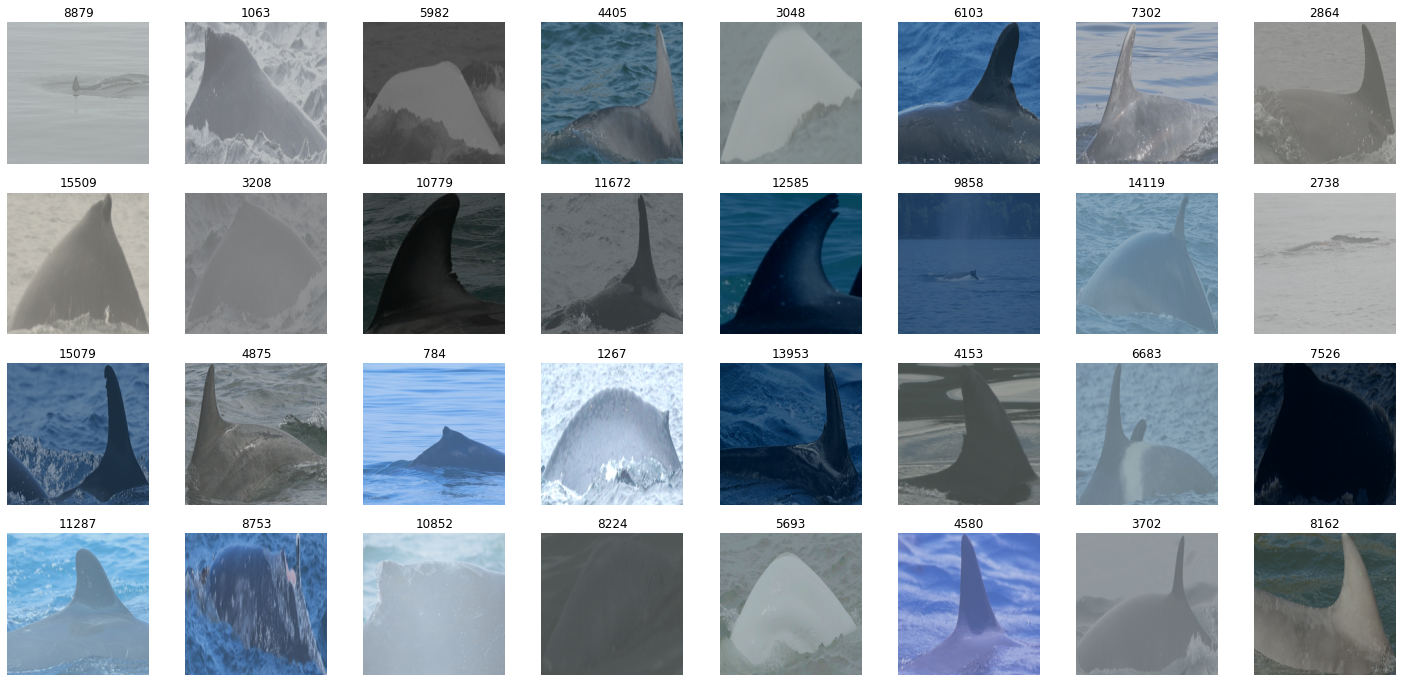

(32, 512, 512, 3)


In [9]:
row = 10; col = 8;
row = min(row,CFG.batch_size//col)
N_TRAIN = count_data_items(train_files)
print(N_TRAIN)
ds = get_training_dataset(train_files)

for (sample,label) in ds:
    img = sample['inp1']
    plt.figure(figsize=(25,int(25*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.title(label['out1'][j].numpy())
        plt.axis('off')
        plt.imshow(img[j,])
        # plt.imshow(img[j,]/255.)
    plt.show()
    break
print(img.shape)

27956


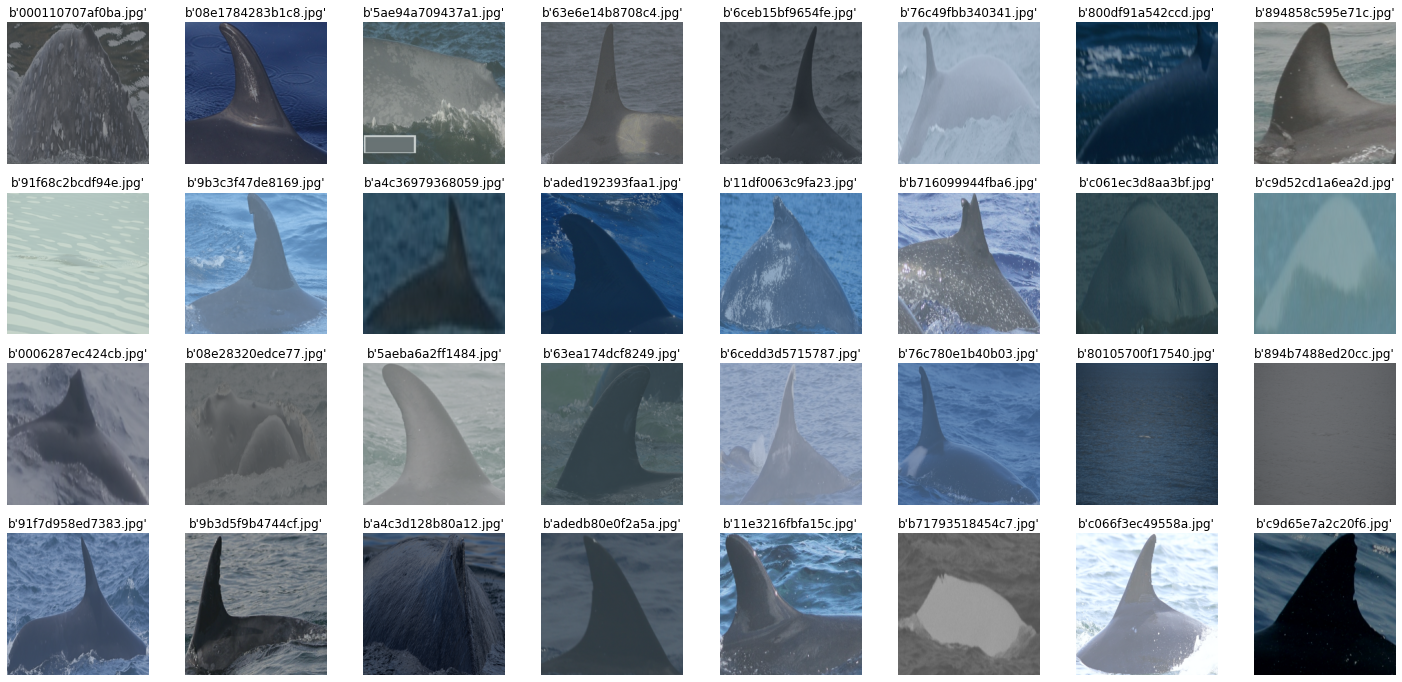

(32, 512, 512, 3)


In [10]:
row = 10; col = 8;
row = min(row,CFG.batch_size//col)
N_TEST = count_data_items(test_files)
print(N_TEST)
ds = get_test_dataset(test_files)

for (img,label) in ds:
    plt.figure(figsize=(25,int(25*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.title(label[j].numpy())
        plt.axis('off')
        plt.imshow(img[j,])
        # plt.imshow(img[j,]/255.)
    plt.show()
    break
print(img.shape)

## Modelo

In [11]:
class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implementa large margin arc distance.

    Referencia:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0, **kwargs):

        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output


class GeM(tf.keras.layers.Layer):
  def __init__(self, trainable = True, init_norm=3.0, normalize=False, **kwargs):
    self.trainable = trainable
    self.init_norm = init_norm
    self.normalize = normalize
    super(GeM, self).__init__(**kwargs)

  def get_config(self):
    config = super().get_config().copy()
    config.update({
        'trainable': self.trainable,
        'init_norm': self.init_norm,
        'normalize': self.normalize
    })
    return config
  
  def build(self, input_shape):
    feature_size = input_shape[-1]
    self.p = self.add_weight(name='norms', shape=(),
                             initializer = tf.keras.initializers.constant(self.init_norm),
                             trainable = self.trainable
                             )
    super(GeM, self).build(input_shape)
  
  def call(self, inputs):
    x = inputs
    x = tf.math.maximum(x, 1e-6)
    x = tf.pow(x, self.p)
    # x = tf.nn.avg_pool(x, self.pool_size, self.pool_size, 'VALID')
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.pow(x, 1.0 / self.p)

    if self.normalize:
      x = tf.nn.l2_normalize(x, 1)
    return x

  def compute_output_shape(self, input_shape):
    return tuple([None, input_shape[-1]])

In [12]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]


def freeze_BN(model):
    for layer in model.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False


# Funcao para criar modelo
def get_model():
    if CFG.head=='arcface':
        head = ArcMarginProduct
    else:
        assert 1==2, "INVALID HEAD"
    
    with strategy.scope():   
        margin = head(
            n_classes = CFG.n_classes, 
            s = 40, 
            m = 0.2915495, 
            name=f'head/{CFG.head}', 
            dtype='float32',
            easy_margin=False,
            ls_eps = 0.0012087
            )

        margin_species = head(
            n_classes = 30, 
            s = 47, 
            m = 0.137386, 
            name=f'head/{CFG.head}_species', 
            dtype='float32',
            easy_margin=False,
            ls_eps = 0.24267
            )

        inp = tf.keras.layers.Input(shape = [CFG.image_size, CFG.image_size, 3], name = 'inp1')
        label = tf.keras.layers.Input(shape = (), name = 'inp2')
        species = tf.keras.layers.Input(shape = (), name = 'inp3')
        
        if CFG.model_type == 'effnetv1':
            # Backbone
            x = EFNS[CFG.eff_net](weights = 'noisy-student', include_top = False)(inp)
            # Embedding
            embed = GeM()(x)
            # embed = tf.keras.layers.GlobalAveragePooling2D()(x)
        elif CFG.model_type == 'resnet152':
            x = tf.keras.applications.resnet_v2.ResNet152V2(include_top = False)(inp)
            embed = GeM()(x)
        elif CFG.model_type == 'tfimm':
            x = tfimm.create_model(CFG.model_name, nb_classes=2056)(inp)
            embed = x

        # embed = tf.keras.layers.Dropout(0.2)(embed)
        embed = tf.keras.layers.Dense(2495)(embed)
        embed = tf.keras.layers.BatchNormalization()(embed)
        embed = tf.keras.layers.PReLU()(embed)
        
        x_ids = margin([embed, label])
        x_species = margin_species([embed, species])
        
        output_ids = tf.keras.layers.Softmax(dtype='float32', name='out1')(x_ids)
        output_species = tf.keras.layers.Softmax(dtype='float32', name='out2')(x_species)
        
        model = tf.keras.models.Model(inputs = [inp, label, species], outputs = [output_ids, output_species])
        embed_model = tf.keras.models.Model(inputs = inp, outputs = embed)  
        
        opt = tf.keras.optimizers.Adam(learning_rate = CFG.lr)
        if CFG.freeze_batch_norm:
            freeze_BN(model)

        model.compile(
            optimizer = opt,
            loss = tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
            ) 
        
        return model,embed_model

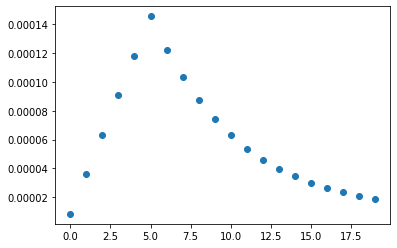

In [13]:
# LR scheduler customizado com 1 warmup
def get_lr_callback(plot=False):
    lr_start   = 0.00000843
    lr_max     = 0.00000455 * CFG.batch_size
    lr_min     = 0.00000843
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.83165
   
    def lrfn(epoch):
        if CFG.resume: # No caso de retomar treino interrompido
            epoch = epoch + CFG.resume_epoch
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr
        
    if plot:
        epochs = list(range(CFG.epochs))
        learning_rates = [lrfn(x) for x in epochs]
        plt.scatter(epochs,learning_rates)
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

get_lr_callback(plot=True)

In [14]:
# Callback de Snapshot
class Snapshot(tf.keras.callbacks.Callback):
    
    def __init__(self,fold,snapshot_epochs=[]):
        super(Snapshot, self).__init__()
        self.snapshot_epochs = snapshot_epochs
        self.fold = fold
        
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch in self.snapshot_epochs:        
            self.model.save_weights(CFG.save_dir+f"/EF{CFG.model_name}_epoch{epoch}.h5")
        self.model.save_weights(CFG.save_dir+f"/{CFG.model_name}_last.h5")

In [15]:
# Separação dados de treino e dados de validação
TRAINING_FILENAMES = [x for i,x in enumerate(train_files) if f'train-{CFG.fold}-' not in x]
VALIDATION_FILENAMES = [x for i,x in enumerate(train_files) if f'train-{CFG.fold}-' in x]
print(len(TRAINING_FILENAMES),len(VALIDATION_FILENAMES),count_data_items(TRAINING_FILENAMES),count_data_items(VALIDATION_FILENAMES))
print(TRAINING_FILENAMES)
print(VALIDATION_FILENAMES)

29 1 49331 1702
['gs://kds-cff8ba45c7d0f4747d04396fe2a7a9ff59eeedc2005aea3fec345318/train-0-1702.tfrec', 'gs://kds-cff8ba45c7d0f4747d04396fe2a7a9ff59eeedc2005aea3fec345318/train-10-1701.tfrec', 'gs://kds-cff8ba45c7d0f4747d04396fe2a7a9ff59eeedc2005aea3fec345318/train-11-1701.tfrec', 'gs://kds-cff8ba45c7d0f4747d04396fe2a7a9ff59eeedc2005aea3fec345318/train-12-1701.tfrec', 'gs://kds-cff8ba45c7d0f4747d04396fe2a7a9ff59eeedc2005aea3fec345318/train-13-1701.tfrec', 'gs://kds-cff8ba45c7d0f4747d04396fe2a7a9ff59eeedc2005aea3fec345318/train-14-1701.tfrec', 'gs://kds-cff8ba45c7d0f4747d04396fe2a7a9ff59eeedc2005aea3fec345318/train-15-1701.tfrec', 'gs://kds-cff8ba45c7d0f4747d04396fe2a7a9ff59eeedc2005aea3fec345318/train-16-1701.tfrec', 'gs://kds-cff8ba45c7d0f4747d04396fe2a7a9ff59eeedc2005aea3fec345318/train-17-1701.tfrec', 'gs://kds-cff8ba45c7d0f4747d04396fe2a7a9ff59eeedc2005aea3fec345318/train-18-1701.tfrec', 'gs://kds-cff8ba45c7d0f4747d04396fe2a7a9ff59eeedc2005aea3fec345318/train-19-1701.tfrec', 'gs:/

In [16]:
if CFG.DEBUG:
    TRAINING_FILENAMES = [TRAINING_FILENAMES[0]]
    VALIDATION_FILENAMES = [VALIDATION_FILENAMES[0]]
    print(len(TRAINING_FILENAMES),len(VALIDATION_FILENAMES),count_data_items(TRAINING_FILENAMES),count_data_items(VALIDATION_FILENAMES))
    test_files = [test_files[0]]

In [17]:
seed_everything(CFG.seed)
VERBOSE = 1
train_dataset = get_training_dataset(TRAINING_FILENAMES)
val_dataset = get_val_dataset(VALIDATION_FILENAMES)
STEPS_PER_EPOCH = (count_data_items(TRAINING_FILENAMES) // CFG.batch_size)*2
train_logger = tf.keras.callbacks.CSVLogger(CFG.save_dir+'/training-log-fold-%i.h5.csv'%CFG.fold)
# Callback de checkpoint para salvar melhor modelo      
sv_loss = tf.keras.callbacks.ModelCheckpoint(
    CFG.save_dir+f"/{CFG.model_name}_loss.h5", monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='min', save_freq='epoch')
# Build do modelo
K.clear_session()
model,embed_model = get_model()
snap = Snapshot(fold=CFG.fold,snapshot_epochs=[5,8])
model.summary()

if CFG.resume:   
    model.load_weights(CFG.resume_model_wts)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp1 (InputLayer)              [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnet-b0 (Functional)   (None, None, None,   4049564     ['inp1[0][0]']                   
                                1280)                                                             
                                                                                                  
 ge_m (GeM)                     (None, 1280)         1           ['efficientnet-b0[0][0]']        
                                                                                              

In [18]:
print('#### Image Size %i with EfficientNet B%i and batch_size %i'%
      (CFG.image_size,CFG.eff_net,CFG.batch_size))

history = model.fit(train_dataset,
                validation_data = val_dataset,
                steps_per_epoch = STEPS_PER_EPOCH,
                epochs = CFG.epochs,
                callbacks = [snap,get_lr_callback(), sv_loss], 
                verbose = VERBOSE)

#### Image Size 512 with EfficientNet B0 and batch_size 32
Epoch 1/20
   6/3082 [..............................] - ETA: 10:10 - loss: 30.0514 - out1_loss: 21.4687 - out2_loss: 8.5828 - out1_sparse_categorical_accuracy: 0.0000e+00 - out1_sparse_top_k_categorical_accuracy: 0.0000e+00 - out2_sparse_categorical_accuracy: 0.0000e+00 - out2_sparse_top_k_categorical_accuracy: 0.0000e+00

3082/3082 [==============================] - 671s 196ms/step - loss: 25.1520 - out1_loss: 19.9287 - out2_loss: 5.2232 - out1_sparse_categorical_accuracy: 0.0000e+00 - out1_sparse_top_k_categorical_accuracy: 0.0000e+00 - out2_sparse_categorical_accuracy: 0.2047 - out2_sparse_top_k_categorical_accuracy: 0.3385 - val_loss: 23.1385 - val_out1_loss: 19.8484 - val_out2_loss: 3.2901 - val_out1_sparse_categorical_accuracy: 0.0000e+00 - val_out1_sparse_top_k_categorical_accuracy: 0.0000e+00 - val_out2_sparse_categorical_accuracy: 0.4471 - val_out2_sparse_top_k_categorical_accuracy: 0.5993 - lr: 8.4300e-06
Epoch 2/20
3082/3082 [==============================] - 588s 191ms/step - loss: 20.5523 - out1_loss: 18.0659 - out2_loss: 2.4864 - out1_sparse_categorical_accuracy: 0.0000e+00 - out1_sparse_top_k_categorical_accuracy: 0.0000e+00 - out2_sparse_categorical_accuracy: 0.5608 - out2_sparse_top_k_categorical_accuracy: 0.7566 - val_loss: 19.7496 - val_out1_loss: 18.5949 - val_out2_loss: 1.1547 - val_

## Carregando Modelo com Melhores Pesos

In [19]:
model.load_weights(CFG.save_dir+f"/{CFG.model_name}_loss.h5")

## Gerando Emneddings Dos Dados de Treino

In [20]:
def get_ids(filename):
    ds = get_test_dataset([filename],get_names=True).map(lambda image, image_name: image_name).unbatch()
    NUM_IMAGES = count_data_items([filename])
    ids = next(iter(ds.batch(NUM_IMAGES))).numpy().astype('U')
    return ids

def get_targets(filename):
    ds = get_eval_dataset([filename],get_targets=True).map(lambda image, target: target).unbatch()
    NUM_IMAGES = count_data_items([filename])
    ids = next(iter(ds.batch(NUM_IMAGES))).numpy()
    return ids

def get_embeddings(filename):
    ds = get_test_dataset([filename],get_names=False)
    embeddings = embed_model.predict(ds,verbose=0)
    return embeddings

def get_predictions(test_df,threshold=0.2):
    predictions = {}
    for i,row in tqdm(test_df.iterrows()):
        if row.image in predictions:
            if len(predictions[row.image])==5:
                continue
            predictions[row.image].append(row.target)
        elif row.confidence>threshold:
            predictions[row.image] = [row.target,'new_individual']
        else:
            predictions[row.image] = ['new_individual',row.target]

    for x in tqdm(predictions):
        if len(predictions[x])<5:
            remaining = [y for y in sample_list if y not in predictions]
            predictions[x] = predictions[x]+remaining
            predictions[x] = predictions[x][:5]
        
    return predictions

def map_per_image(label, predictions):
    try:
        return 1 / (predictions[:5].index(label) + 1)
    except ValueError:
        return 0.0
    
# Json com a codificação id do individuo para numero da classe
f = open (CFG.root_dir + '/individual_ids_new.json', "r")
target_encodings = json.loads(f.read())
target_encodings = {target_encodings[x]:x for x in target_encodings}
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']

In [21]:
# Gerando embeddings dos dados de treino. 
# Estes embeddings irão compor a base de dados para consulta
train_targets = []
train_embeddings = []
for filename in tqdm(TRAINING_FILENAMES):
    embeddings = get_embeddings(filename)
    targets = get_targets(filename)
    train_embeddings.append(embeddings)
    train_targets.append(targets)
train_embeddings = np.concatenate(train_embeddings)
train_targets = np.concatenate(train_targets)

  0%|          | 0/29 [00:00<?, ?it/s]

In [22]:
# Criando KNN
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=CFG.KNN,metric='cosine')
neigh.fit(train_embeddings)

NearestNeighbors(metric='cosine', n_neighbors=100)

## Calculando Metricas

In [23]:
test_ids = []
test_nn_distances = []
test_nn_idxs = []
val_targets = []
val_embeddings = []
for filename in tqdm(VALIDATION_FILENAMES):
    embeddings = get_embeddings(filename)
    targets = get_targets(filename)
    ids = get_ids(filename)
    distances,idxs = neigh.kneighbors(embeddings, CFG.KNN, return_distance=True)
    test_ids.append(ids)
    test_nn_idxs.append(idxs)
    test_nn_distances.append(distances)
    val_embeddings.append(embeddings)
    val_targets.append(targets)
test_nn_distances = np.concatenate(test_nn_distances)
test_nn_idxs = np.concatenate(test_nn_idxs)
test_ids = np.concatenate(test_ids)
val_embeddings = np.concatenate(val_embeddings)
val_targets = np.concatenate(val_targets)

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
allowed_targets = set([target_encodings[x] for x in np.unique(train_targets)])
val_targets_df = pd.DataFrame(np.stack([test_ids,val_targets],axis=1),columns=['image','target'])
val_targets_df['target'] = val_targets_df['target'].astype(int).map(target_encodings)
val_targets_df.loc[~val_targets_df.target.isin(allowed_targets),'target'] = 'new_individual'
val_targets_df.target.value_counts()

new_individual    307
37c7aba965a5       16
bc1eb2241633        9
938b7e931166        8
a6e325d8e924        7
                 ... 
425be47a37e6        1
7a8863eb9227        1
ce873781a2c4        1
d7b787c2064e        1
416c48277ab4        1
Name: target, Length: 1017, dtype: int64

In [25]:
test_df = []
for i in tqdm(range(len(test_ids))):
    id_ = test_ids[i]
    targets = train_targets[test_nn_idxs[i]]
    distances = test_nn_distances[i]
    subset_preds = pd.DataFrame(np.stack([targets,distances],axis=1),columns=['target','distances'])
    subset_preds['image'] = id_
    test_df.append(subset_preds)
test_df = pd.concat(test_df).reset_index(drop=True)
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df['target'] = test_df['target'].map(target_encodings)
test_df.to_csv('val_neighbors.csv')
test_df.image.value_counts().value_counts()

  0%|          | 0/1702 [00:00<?, ?it/s]

1     61
83    31
21    27
86    26
80    26
      ..
4      7
3      7
6      6
8      5
5      5
Name: image, Length: 100, dtype: int64

In [26]:
# Calculando Melhor CV
best_th = 0
best_cv = 0
for th in [0.1*x for x in range(11)]:
    all_preds = get_predictions(test_df,threshold=th)
    cv = 0
    for i,row in val_targets_df.iterrows():
        target = row.target
        preds = all_preds[row.image]
        val_targets_df.loc[i,th] = map_per_image(target,preds)
    cv = val_targets_df[th].mean()
    print(f"CV at threshold {th}: {cv}")
    if cv>best_cv:
        best_th = th
        best_cv = cv

0it [00:00, ?it/s]

  0%|          | 0/1702 [00:00<?, ?it/s]

CV at threshold 0.0: 0.6096063454759107


0it [00:00, ?it/s]

  0%|          | 0/1702 [00:00<?, ?it/s]

CV at threshold 0.1: 0.6096063454759107


0it [00:00, ?it/s]

  0%|          | 0/1702 [00:00<?, ?it/s]

CV at threshold 0.2: 0.6096063454759107


0it [00:00, ?it/s]

  0%|          | 0/1702 [00:00<?, ?it/s]

CV at threshold 0.30000000000000004: 0.6096063454759107


0it [00:00, ?it/s]

  0%|          | 0/1702 [00:00<?, ?it/s]

CV at threshold 0.4: 0.6143066980023503


0it [00:00, ?it/s]

  0%|          | 0/1702 [00:00<?, ?it/s]

CV at threshold 0.5: 0.6560223266745007


0it [00:00, ?it/s]

  0%|          | 0/1702 [00:00<?, ?it/s]

CV at threshold 0.6000000000000001: 0.6366333725029377


0it [00:00, ?it/s]

  0%|          | 0/1702 [00:00<?, ?it/s]

CV at threshold 0.7000000000000001: 0.5717097532314923


0it [00:00, ?it/s]

  0%|          | 0/1702 [00:00<?, ?it/s]

CV at threshold 0.8: 0.5091363102232667


0it [00:00, ?it/s]

  0%|          | 0/1702 [00:00<?, ?it/s]

CV at threshold 0.9: 0.4685957696827262


0it [00:00, ?it/s]

  0%|          | 0/1702 [00:00<?, ?it/s]

CV at threshold 1.0: 0.45420094007050527


In [27]:
print("Best threshold",best_th)
print("Best cv",best_cv)
val_targets_df.describe()

Best threshold 0.5
Best cv 0.6560223266745007


,0.0,0.1,0.2,0.30000000000000004,0.4,0.5,0.6000000000000001,0.7000000000000001,0.8,0.9,1.0
count,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000
mean,0.609606,0.609606,0.609606,0.609606,0.614307,0.656022,0.636633,0.571710,0.509136,0.468596,0.454201
std,0.416099,0.416099,0.416099,0.416099,0.417657,0.428980,0.424265,0.401316,0.367166,0.337084,0.324518
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000
50%,0.500000,0.500000,0.500000,0.500000,1.000000,1.000000,1.000000,0.500000,0.500000,0.500000,0.500000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
val_targets_df['is_new_individual'] = val_targets_df.target=='new_individual'
print(val_targets_df.is_new_individual.value_counts().to_dict())
val_scores = val_targets_df.groupby('is_new_individual').mean().T
val_scores['adjusted_cv'] =  val_scores[True]*0.1+val_scores[False]*0.9
best_threshold_adjusted = val_scores['adjusted_cv'].idxmax()
print("best_threshold",best_threshold_adjusted)
val_scores

{False: 1395, True: 307}
best_threshold 0.5


is_new_individual,False,True,adjusted_cv
0.0,0.633728,0.500000,0.620355
0.1,0.633728,0.500000,0.620355
0.2,0.633728,0.500000,0.620355
0.30000000000000004,0.633728,0.500000,0.620355
0.4,0.633011,0.529316,0.622641
0.5,0.621900,0.811075,0.640817
0.6000000000000001,0.563835,0.967427,0.604194
0.7000000000000001,0.478889,0.993485,0.530349
0.8,0.401111,1.000000,0.461000
0.9,0.351649,1.000000,0.416484


## Salvando Embeddings dos Dados de Treino

Agora é salvar os embeddings dos dados de treino. Eles serão usados para consultas no futuro

In [29]:
train_embeddings = np.concatenate([train_embeddings,val_embeddings])
train_targets = np.concatenate([train_targets,val_targets])
print(train_embeddings.shape,train_targets.shape)

(51033, 2495) (51033,)


In [30]:
train_all_targets = []
train_all_embeddings = []
for filename in tqdm(train_files):
    embeddings = get_embeddings(filename)
    targets = get_targets(filename)
    train_all_embeddings.append(embeddings)
    train_all_targets.append(targets)
train_all_embeddings = np.concatenate(train_all_embeddings)
train_all_targets = np.concatenate(train_all_targets)

  0%|          | 0/30 [00:00<?, ?it/s]

In [31]:
np.save(f'{CFG.save_dir}/train_embeddings.npy', train_embeddings)
np.save(f'{CFG.save_dir}/train_targets.npy', train_targets)

np.save(f'{CFG.save_dir}/train_all_embeddings.npy', train_all_embeddings)
np.save(f'{CFG.save_dir}/train_all_targets.npy', train_all_targets)

## Carregando Dataset dos Embeddings e Identificando Baleias e Golfinhos

In [32]:
train_embeddings = np.load(f'{CFG.save_dir}/train_embeddings.npy')
train_targets = np.load(f'{CFG.save_dir}/train_targets.npy')
train_all_embeddings = np.load(f'{CFG.save_dir}/train_all_embeddings.npy')
train_all_targets = np.load(f'{CFG.save_dir}/train_all_targets.npy')

In [33]:
# Preparando KNN
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=CFG.KNN,metric='cosine')
neigh.fit(train_embeddings)

NearestNeighbors(metric='cosine', n_neighbors=100)

In [34]:
test_ids = []
test_nn_distances = []
test_nn_idxs = []
test_embeddings = []
for filename in tqdm(test_files):
    embeddings = get_embeddings(filename)
    ids = get_ids(filename)
    distances,idxs = neigh.kneighbors(embeddings, CFG.KNN, return_distance=True)
    test_ids.append(ids)
    test_nn_idxs.append(idxs)
    test_nn_distances.append(distances)
    test_embeddings.append(embeddings)
test_embeddings = np.concatenate(test_embeddings)
test_nn_distances = np.concatenate(test_nn_distances)
test_nn_idxs = np.concatenate(test_nn_idxs)
test_ids = np.concatenate(test_ids)

  0%|          | 0/28 [00:00<?, ?it/s]

In [35]:
# Salvando as Identificações Realizadas
print(test_embeddings.shape)
np.save(f'{CFG.save_dir}/test_embeddings.npy', test_embeddings)
np.save(f'{CFG.save_dir}/test_ids.npy', test_ids)

(27956, 2495)


In [36]:
sample_submission = pd.read_csv(CFG.root_dir + '/sample_submission.csv',index_col='image')
print(len(test_ids),len(sample_submission))
test_df = []
for i in tqdm(range(len(test_ids))):
    id_ = test_ids[i]
    targets = train_targets[test_nn_idxs[i]]
    distances = test_nn_distances[i]
    subset_preds = pd.DataFrame(np.stack([targets,distances],axis=1),columns=['target','distances'])
    subset_preds['image'] = id_
    test_df.append(subset_preds)
test_df = pd.concat(test_df).reset_index(drop=True)
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df['target'] = test_df['target'].map(target_encodings)
test_df.to_csv('test_neighbors.csv')
test_df.image.value_counts().value_counts()

27956 27956


  0%|          | 0/27956 [00:00<?, ?it/s]

82    423
86    402
80    395
79    390
85    385
     ... 
6      95
5      79
2      74
4      60
3      46
Name: image, Length: 100, dtype: int64

In [37]:
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']

In [38]:
predictions = {}
for i,row in tqdm(test_df.iterrows()):
    if row.image in predictions:
        if len(predictions[row.image])==5:
            continue
        predictions[row.image].append(row.target)
    elif row.confidence>0.7:
        predictions[row.image] = [row.target,'new_individual']
    else:
        predictions[row.image] = ['new_individual',row.target]
        
for x in tqdm(predictions):
    if len(predictions[x])<5:
        remaining = [y for y in sample_list if y not in predictions]
        predictions[x] = predictions[x]+remaining
        predictions[x] = predictions[x][:5]
    predictions[x] = ' '.join(predictions[x])
    
predictions = pd.Series(predictions).reset_index()
predictions.columns = ['image','predictions']
predictions.to_csv(CFG.save_dir + '/submission_th_07.csv',index=False)
predictions.head()

0it [00:00, ?it/s]

  0%|          | 0/27956 [00:00<?, ?it/s]

,image,predictions
0,5c9e04a6e6a9a2.jpg,547afd43d437 new_individual c295e46e85d8 3028e...
1,3c52966f74d2ad.jpg,978520860ceb new_individual cfd34e95a962 fd15f...
2,f628b07bdea128.jpg,191e293af2b5 new_individual 35bc67b3b071 44bd3...
3,36bca13dba592a.jpg,7fdeba948ee8 new_individual 5cdd8c0d46d9 3db41...
4,50df0a954eb94c.jpg,713eb1a00c3d new_individual bcf6229a65e6 b848a...
